In [1]:
from importlib import reload
import platform, os, sys, datetime, re, itertools
from os.path import join
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
import cvt
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
# from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window

In [2]:
reload(cvt.TrAQ.Trial)
from cvt.TrAQ.Trial import Trial
reload(cvt.TrAQ.Tank)
from cvt.TrAQ.Tank import Tank

# Load a trial

In [3]:
# trial_files = sorted(glob('../tracking/full/*/trial.pik'))
trial_files = sorted(glob('../tracking/partial/*/trial.pik'))
display(trial_files)

trial = Trial()
trial.load(trial_files[1])
display(trial.df[:3])
# trial.df.to_excel(trial.output_dir+'/df.xlsx')

['../tracking/partial/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/trial.pik',
 '../tracking/partial/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000/trial.pik']


        Trial loaded from ../tracking/partial/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000/trial.pik 


0                                        1              \
              x_px        y_px       ang  area         x_px        y_px   
frame                                                                     
1801   1500.792023  735.712251  0.062246  58.5  1471.845938  726.630252   
1802   1501.182336  735.803419  0.034510  58.5  1471.564738  726.721763   
1803   1500.944444  735.836111  0.039423  60.0  1471.494152  726.795322   

                                 2                                       3  \
            ang  area         x_px        y_px       ang  area        x_px   
frame                                                                        
1801  -0.679472  59.5  1103.768448  816.681934 -0.290330  65.5  850.261728   
1802  -0.698818  60.5  1103.239186  816.865140 -0.288911  65.5  850.378788   
1803  -0.718249  57.0  1103.624339  816.595238 -0.260666  63.0  850.536341   

                                             4                              
             y_px       ang  area         x_px        y_px       ang  area  
frame                                                                       
1801   644.335802  0.231995  67.5  1092.965035  861.948718  1.481761  71.5  
1802   644.348485  0.220397  66.0  1092.986207  861.894253  1.485195  72.5  
1803   644.348371  0.223180  66.5  1092.936508  861.596372  1.479325  73.5

# Compute spatial and kinematic quantities

In [4]:
trial.convert_pixels_to_cm()

fish = trial.df.columns.levels[0]

for f in fish:
    
    trial.df[f,'d_wall'] = trial.tank.r_cm - np.hypot(trial.df[f,'x'],trial.df[f,'y'])
    
    trial.df[f,'v_x']    = trial.df[f,'x'].diff()*trial.fps
    trial.df[f,'v_y']    = trial.df[f,'y'].diff()*trial.fps
    trial.df[f,'v']      = np.hypot(trial.df[f,'v_x'],trial.df[f,'v_y'])
    
    ang_diff             = trial.df[f,'ang'].diff()
    ang_diff            -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    trial.df[f,'v_ang']  = ang_diff*trial.fps
    
# Reorder columns.
# trial.df = trial.df.sort_index(axis=1) # Sort alphabetically, which also sorts by fish.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 'ang', 'v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'd_wall'] ]
trial.df = trial.df.reindex(columns=columns)
display(trial.df[:3])

0                                                            \
              x_px        y_px  area       ang     v_ang         x         y   
frame                                                                          
1801   1500.792023  735.712251  58.5  0.062246       NaN  4.087090 -1.794069   
1802   1501.182336  735.803419  58.5  0.034510 -0.832095  4.091488 -1.795096   
1803   1500.944444  735.836111  60.0  0.039423  0.147403  4.088807 -1.795465   

                                     ...           4                  \
            v_x       v_y         v  ...        y_px  area       ang   
frame                                ...                               
1801        NaN       NaN       NaN  ...  861.948718  71.5  1.481761   
1802   0.131967 -0.030824  0.135519  ...  861.894253  72.5  1.485195   
1803  -0.080432 -0.011053  0.081188  ...  861.596372  73.5  1.479325   

                                                                             
          v_ang         x         y       v_x       v_y         v    d_wall  
frame                                                                        
1801        NaN -0.509177 -3.216771       NaN       NaN       NaN  1.543180  
1802   0.103016 -0.508939 -3.216158  0.007158  0.018415  0.019757  1.543823  
1803  -0.176081 -0.509499 -3.212800 -0.016803  0.100715  0.102107  1.547051  

[3 rows x 55 columns]

# Perform cuts

{'d_wall': 1.0,
 'v': 0.9940066592674806,
 'v_ang': 0.9988901220865705,
 'final': 0.9940066592674806}

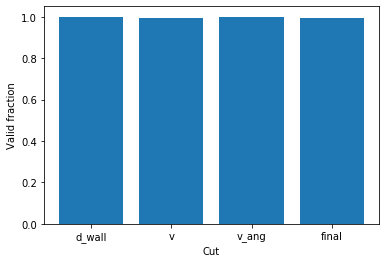

0                                                              \
            ang     v_ang         x         y       v_x       v_y         v   
frame                                                                         
1801        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1802   0.034510 -0.832095  4.091488 -1.795096  0.131967 -0.030824  0.135519   
1803   0.039423  0.147403  4.088807 -1.795465 -0.080432 -0.011053  0.081188   

                        1            ...         3                   4  \
         d_wall       ang     v_ang  ...         v    d_wall       ang   
frame                                ...                                 
1801        NaN       NaN       NaN  ...       NaN       NaN       NaN   
1802   0.332042 -0.698818 -0.580367  ...  0.039810  1.467979  1.485195   
1803   0.334349 -0.718249 -0.582945  ...  0.053269  1.469708  1.479325   

                                                                             
          v_ang         x         y       v_x       v_y         v    d_wall  
frame                                                                        
1801        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1802   0.103016 -0.508939 -3.216158  0.007158  0.018415  0.019757  1.543823  
1803  -0.176081 -0.509499 -3.212800 -0.016803  0.100715  0.102107  1.547051  

[3 rows x 40 columns]

In [5]:
cut_ranges = { 'd_wall': [0,trial.tank.r_cm], 
               'v':      [0,np.inf], 
               'v_ang':  [-np.inf,np.inf] }


# Locate fish/frame combinations that didn't make the cut(s).
cut_names = [ 'cut_'+q for q in cut_ranges.keys() ]
valid_fraction = {}
for f in fish:
    for q,(vmin,vmax) in cut_ranges.items():
        trial.df[f,'cut_'+q]  = (trial.df[f,q]>vmin) & (trial.df[f,q]<vmax)
    trial.df[f,'cut_final'] = trial.df.loc[:,(f,cut_names)].all(axis=1)

    
# # For each fish, compute the fraction of points that made it through each cut.
# valid_fraction = {}
# for f in fish:
#     for c in list(cut_ranges.keys())+['final']:
#         valid_fraction[f,c] = trial.df[f,'cut_'+c].mean()
# display(valid_fraction)

# Compute the fraction of points that made it through each cut.
valid_fraction = {}
for c in list(cut_ranges.keys())+['final']:
    B = [trial.df[f,'cut_'+c] for f in fish]
    valid_fraction[c] = sum([b.sum() for b in B])/sum([len(b) for b in B])
display(valid_fraction)

# Plot the fraction of points that made it through each cut.
plt.bar(*zip(*valid_fraction.items()))
plt.xlabel('Cut')
plt.ylabel('Valid fraction')
plt.show()


# Reorder columns.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 
                                          'ang', 'v_ang', 'cut_v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'cut_v', 
                                          'd_wall', 'cut_d_wall', 
                                          'cut_final'] ]
trial.df = trial.df.reindex(columns=columns)
# display(trial.df[0][:3])


# Create a filtered dataframe.
cols = ['ang', 'v_ang', 'x', 'y', 'v_x', 'v_y', 'v', 'd_wall']
df = trial.df.loc[:,(slice(None),cols)].copy()
for f in fish:
    df.loc[~trial.df[f,'cut_final'],f] = np.nan
display(df[:3])    

# Compute and plot distributions

TODO: Compute histogram for each fish, then use the standard error as the uncertainty on the distribution.

### Distance to the wall

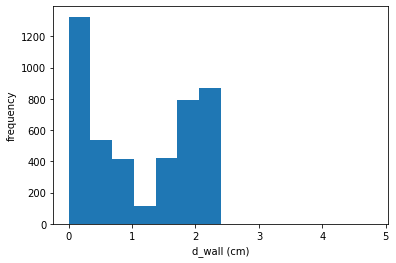

In [6]:
quantity = 'd_wall'
unit = 'cm'
bins = np.linspace(0,trial.tank.r_cm,15)

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.show()

### Velocity

/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


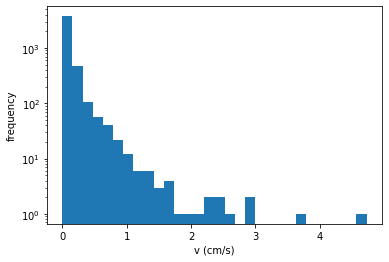

In [7]:
quantity = 'v'
unit = 'cm/s'
bins = 30

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [8]:
# fast = trial.df.loc[:,(slice(None),'v')]>6
# print(np.nonzero(fast.values))
# display(trial.df.iloc[266:269][4])

### Angular velocity

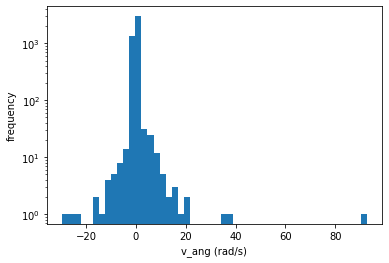

In [9]:
quantity = 'v_ang'
unit = 'rad/s'
bins = 50

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [10]:
# At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# corresponds to about pi/3 in one frame.
print('v_ang for pi/3 in (1/30) second:',np.pi/3*trial.fps)

print('Instances of unusually high v_ang:')
for f in fish:
    ang_diff  = trial.df[f,'ang'].diff()
    ang_diff -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
    for i in I:
        display(trial.df[f,'ang'][i-1:i+2])

v_ang for pi/3 in (1/30) second: 31.415926535897928
Instances of unusually high v_ang:


/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


frame
2044    0.923934
2045    2.089075
2046    1.706627
Name: (0, ang), dtype: float64

frame
1978   -0.915164
1979    2.170932
1980    2.202160
Name: (1, ang), dtype: float64

frame
2555   -0.668096
2556    0.598230
2557   -0.386382
Name: (2, ang), dtype: float64

### Pair distance-pair angle distribution

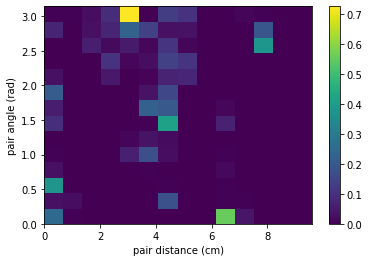

In [11]:
bins_d = np.linspace(0,2*trial.tank.r_cm,15)
bins_a = np.linspace(0,np.pi,15)
H      = [] # np.zeros((len(bins_d)-1,len(bins_a)-1))
for f1,f2 in itertools.combinations(fish,2):
#     print(f1,f2)
    d = np.hypot(df[f1,'x']-df[f2,'x'],df[f1,'y']-df[f2,'y'])
    a = df[f1,'ang']-df[f2,'ang']
    a = a - 2*np.pi*np.rint(a/(2*np.pi))
    
    h,_,_ = np.histogram2d(d,a,bins=(bins_d,bins_a),normed=True)
    H.append(h)

H   = np.mean(H,axis=0)
plt.pcolormesh(bins_d,bins_a,H.T)
plt.xlabel('pair distance (cm)')
plt.ylabel('pair angle (rad)')
plt.colorbar()
plt.show()

# Angular dynamics

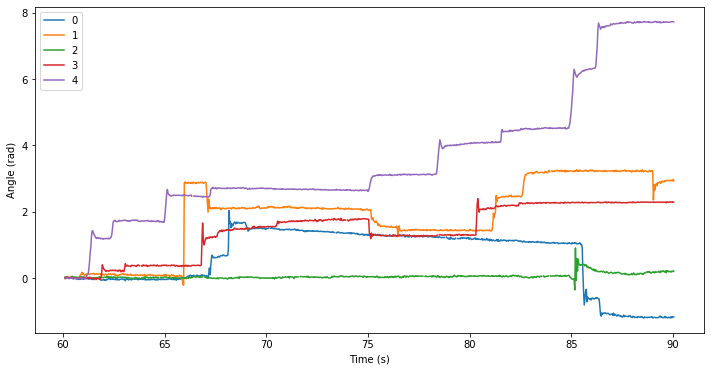

In [12]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib inline

plt.figure(figsize=(12,6))
for f in fish:
    t    = df.index/trial.fps
    ang  = df[f,'ang']

    dang = ang.diff()
    dang = dang - 2*np.pi*np.rint(dang/(2*np.pi))
    ang  = np.cumsum(dang)

    I = (t>297) & (t<301)
    # t,th = t[I],th[I]

    # plt.figure(figsize=(12,6))
    # plt.xlim(297,301)
    plt.plot(t,ang,label=f) #,marker='.')

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
# plt.savefig(trial.make_fig_file('angle-vs-time',''),**trial.plot_options)
plt.legend()
plt.show()